# Classifying MNIST with a simple model and quantum embeddings

Inspired by:  https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

Useful imports

In [1]:
# for the Boson Sampler
import perceval as pcvl
#import perceval.providers.scaleway as scw  # Uncomment to allow running on scaleway

# for the machine learning model
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from model import *
from boson_sampler import BosonSampler
from utils import MNIST_partial, accuracy, plot_training_metrics, MNIST_partial2
from pqnn_model import QuantumLayer, OutputMappingStrategy
import math

## Definition of the Boson Sampler

In [2]:
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#to display it
# pcvl.pdisplay(bs.create_circuit())
# define device to run the model

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE = {device}')

DEVICE = cpu


## Dataset : a subset of MNIST dataset

In [3]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split = 'train')
val_dataset = MNIST_partial(split='val')

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

In [4]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])


## Training loop

In [5]:
def train_model(model, optimizer, num_epochs, train_loader, val_loader, device, save=False):
    criterion = nn.CrossEntropyLoss()
    history_train_accuracy, history_val_accuracy, history_train_loss, history_val_loss = [],[],[],[]
    for epoch in range(num_epochs):
        # training
        model.train()
        train_loss_epoch = []
        train_acc_epoch = []
        for step, batch in enumerate(tqdm(train_loader)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_epoch.append(loss.item())
            acc = accuracy(output, labels)
            train_acc_epoch.append(acc)
        model.eval()
        val_loss_epoch = []
        val_acc_epoch = []
        for step, batch in enumerate(tqdm(val_loader)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss_epoch.append(loss.item())
            acc = accuracy(output, labels)
            val_acc_epoch.append(acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {sum(train_loss_epoch)/len(train_loss_epoch):.4f}, Val Loss: {sum(val_loss_epoch)/len(val_loss_epoch):.4f}, Train Acc: {sum(train_acc_epoch)/len(train_acc_epoch):.4f}, Val Acc: {sum(val_acc_epoch)/len(val_acc_epoch):.4f}")
        history_train_loss.append(sum(train_loss_epoch)/len(train_loss_epoch))
        history_train_accuracy.append(sum(train_acc_epoch)/len(train_acc_epoch))
        history_val_loss.append(sum(val_loss_epoch)/len(val_loss_epoch))
        history_val_accuracy.append(sum(val_acc_epoch)/len(val_acc_epoch))
    if save == True:
        PATH = './MNIST_resnet.pth'
        torch.save(model.state_dict(), PATH)
    plot_training_metrics(history_train_accuracy, history_val_accuracy, history_train_loss, history_val_loss)


    # validation

## Model definition

The goal is to perform transfer learning from task A to MNIST. First, we try with task A being ImageNet. Therefore :
* We take a ResNet18 pretrained on ImageNet
* Classical comparison : we train the input layer and the last FC layer to classify MNIST
* Quantum training : the FC layer is replaced by a QuantumLayer and a linear layer to map the output of the QuantumLayer to the 10 classes

### Initialisation of the model

In [6]:
import torchvision

In [7]:
pretrained_model = torchvision.models.resnet18()

In [8]:
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Classical Transfer Learning

In [9]:
MODES = 12
# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# change last FC layer to map to the 10 classes of MNIST
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=10, bias = True))
# almost equivalent to LoRA weights decomposition: instead of having 512x10 weights (+ bias), we have (512*MODES)+(MODES*10) = MODES(512+1


100%|██████████| 60/60 [00:02<00:00, 28.78it/s]


Epoch 1/5: Train Loss: 0.5584, Val Loss: 0.2356, Train Acc: 0.8248, Val Acc: 0.9467


100%|██████████| 60/60 [00:01<00:00, 41.70it/s]


Epoch 2/5: Train Loss: 0.2406, Val Loss: 0.1747, Train Acc: 0.9282, Val Acc: 0.9567


100%|██████████| 60/60 [00:02<00:00, 21.45it/s]


Epoch 3/5: Train Loss: 0.1888, Val Loss: 0.1203, Train Acc: 0.9483, Val Acc: 0.9650


100%|██████████| 60/60 [00:01<00:00, 30.56it/s]


Epoch 4/5: Train Loss: 0.1339, Val Loss: 0.0806, Train Acc: 0.9613, Val Acc: 0.9800


100%|██████████| 60/60 [00:02<00:00, 29.49it/s]


Epoch 5/5: Train Loss: 0.1216, Val Loss: 0.1079, Train Acc: 0.9683, Val Acc: 0.9683


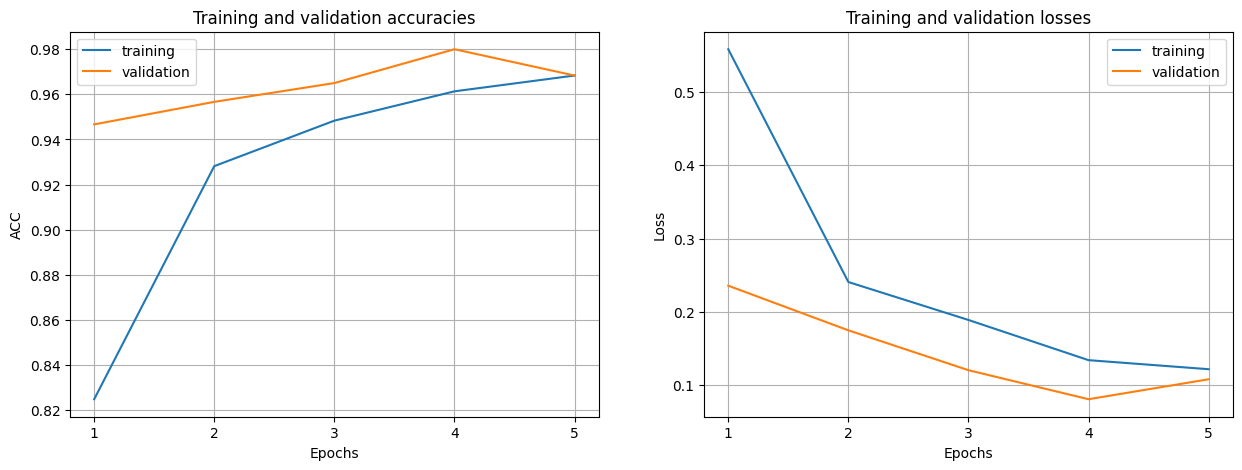

In [10]:
# the model is fully trained
model = pretrained_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model,optimizer,5,train_loader,val_loader, device, save=True)

In [11]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial2(split = 'train')
val_dataset = MNIST_partial2(split='val')


batch_size = 10
# train_loader = DataLoader(filtered_dataset, batch_size, shuffle = True)
# val_loader = DataLoader(filtered_dataset_val, batch_size, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

100%|██████████| 14/14 [00:00<00:00, 45.34it/s]


Epoch 1/5: Train Loss: 0.0763, Val Loss: 0.0043, Train Acc: 0.9810, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 47.59it/s]


Epoch 2/5: Train Loss: 0.0987, Val Loss: 0.0041, Train Acc: 0.9862, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 47.97it/s]


Epoch 3/5: Train Loss: 0.0104, Val Loss: 0.0013, Train Acc: 0.9983, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 36.92it/s]


Epoch 4/5: Train Loss: 0.0174, Val Loss: 0.0003, Train Acc: 0.9957, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 40.78it/s]


Epoch 5/5: Train Loss: 0.0006, Val Loss: 0.0001, Train Acc: 1.0000, Val Acc: 1.0000


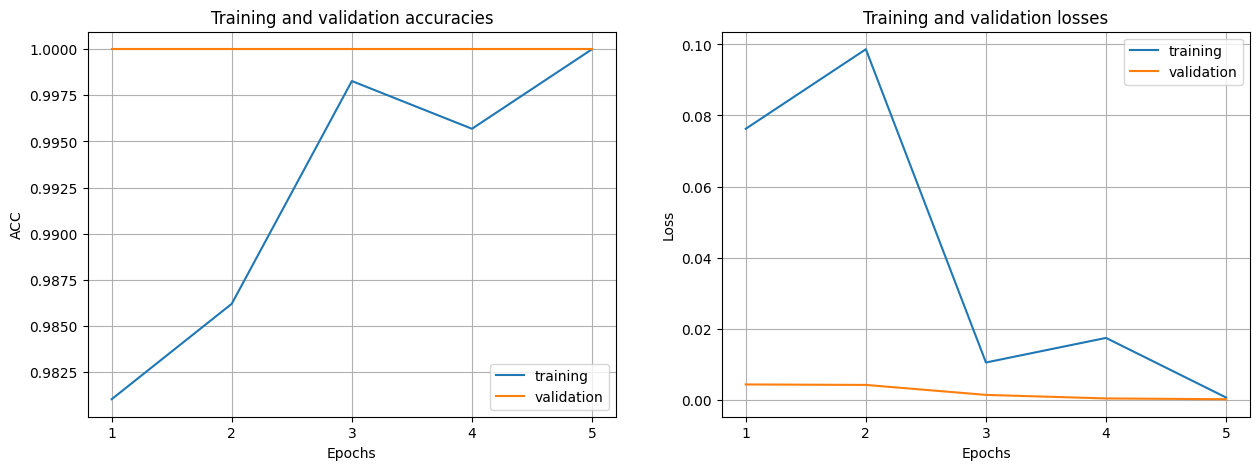

In [14]:
# we only train the first conv and fc layer
MODES = 12
pretrained_model = torchvision.models.resnet18()
# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=10, bias = True))

pretrained_model.load_state_dict(torch.load('./MNIST_resnet.pth', weights_only=True))
# change last FC layer to map to the 10 classes of MNIST
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=2, bias = True))


model = pretrained_model.to(device)
model.requires_grad = False
model.conv1.requires_grad = True
model.fc.requires_grad = True

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
train_model(model,optimizer,5,train_loader,val_loader, device)


### Quantum Transfer Learning

In [17]:
MODES = 12
hidden_dim = 128
pretrained_model = torchvision.models.resnet18()
# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=10, bias = True))

pretrained_model.load_state_dict(torch.load('./MNIST_resnet.pth', weights_only=True))


# first, we consider we have as may modes as features
encoding_circuit = pcvl.Circuit(MODES)
for i in range(0,MODES,2):
    encoding_circuit.add(i , pcvl.BS())
for i in range(1,MODES-1,2):
    encoding_circuit.add(i , pcvl.BS())
for i in range(hidden_dim):
    feat = pcvl.P(f"feat-{i + 1}")
    encoding_circuit.add(i % MODES, pcvl.PS(feat))
pcvl.pdisplay(encoding_circuit)
trainable_circuit = pcvl.GenericInterferometer(MODES, lambda i: (pcvl.BS() #theta=pcvl.P(f"bs_1_{i}")
                                                             .add(0, pcvl.PS(pcvl.P(f"phase_train_1_{i}")))
                                                             .add(0, pcvl.BS()) #theta=pcvl.P(f"bs_1_{i}")
                                                             .add(0, pcvl.PS(pcvl.P(f"phase_train_2_{i}")))
                                                             )
                                          )
circuit = pcvl.Circuit(MODES)
circuit.add(0, encoding_circuit, merge=True)
circuit.add(0, trainable_circuit, merge=True)

input_state = [(i + 1) % 2 for i in range(MODES)]
photon_count = sum(input_state)
qlayer = QuantumLayer(
            input_size=hidden_dim,
            output_size=10, # but we do not use it
            circuit = circuit,
            input_state = input_state,
            trainable_parameters= [p.name for p in circuit.get_parameters() if not p.name.startswith("feat")],
            output_mapping_strategy=OutputMappingStrategy.LINEAR)

# change last FC layer to QLayer + linear layer
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=hidden_dim, bias=True),
                                    qlayer)


In [18]:
model = pretrained_model.to(device)

#model.requires_grad = False
#model.conv1.requires_grad = True
#model.fc.requires_grad = True

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)
train_model(model,optimizer,5,train_loader,val_loader, device)

100%|██████████| 14/14 [05:23<00:00, 23.09s/it]


Epoch 1/5: Train Loss: 1.2939, Val Loss: 0.8457, Train Acc: 0.5302, Val Acc: 0.5119


100%|██████████| 14/14 [05:55<00:00, 25.36s/it]


Epoch 2/5: Train Loss: 0.7707, Val Loss: 0.7365, Train Acc: 0.5358, Val Acc: 0.4762


  0%|          | 0/116 [00:15<?, ?it/s]


KeyboardInterrupt: 

## Training loop

## Model training

In [ ]:
# end session if needed
if session is not None:
    session.stop()